In [1]:
import os, sys, platform
os.add_dll_directory(r"E:\openslide-bin-4.0.0.8-windows-x64\bin")
import torch, PIL, openslide
from ctypes import cdll
cdll.LoadLibrary("libopenslide-0.dll")
from pathlib import Path
from tqdm import tqdm
import numpy as np
from skimage import draw
from xml.dom import minidom
import matplotlib.pyplot as plt
import cv2

In [3]:
#Data root
DATA_ROOT = Path(r"CellVIT\TrainingData\TrainingImages_and_Annotations")
OUT_ROOT  = Path(r"")
PATCH_SIZE = 512   
MIN_POLY_AREA = 10 

(OUT_ROOT / "images").mkdir(parents=True, exist_ok=True)
(OUT_ROOT / "labels").mkdir(parents=True, exist_ok=True)
(OUT_ROOT / "debug").mkdir(parents=True, exist_ok=True)


In [5]:
cases = [d for d in os.listdir(DATA_ROOT) if (DATA_ROOT / d).is_dir()]
print(f" {len(cases)} patients：")

pairs = []
missing = []
for c in cases:
    case_path = DATA_ROOT / c
    svs_list = [f for f in os.listdir(case_path) if f.lower().endswith(".svs")]
    for svs in svs_list:
        name = os.path.splitext(svs)[0]
        xml = name + ".xml"
        if (case_path / xml).exists():
            pairs.append((case_path / svs, case_path / xml))
        else:
            missing.append((case_path / svs))
print(f"✅ find {len(pairs)}  (svs, xml) pairs")



 46 patients：
✅ find 209  (svs, xml) pairs


In [7]:
def peek_xml_labels(xml_path):
    xmldoc = minidom.parse(str(xml_path))
    names = []
    for ann in xmldoc.getElementsByTagName("Annotation"):
        for attr in ann.getElementsByTagName("Attribute"):
            if attr.hasAttribute("Name"):
                names.append(attr.getAttribute("Name"))
    return sorted(set(names))

sample_xml = pairs[0][1]
print("Example XML:", sample_xml)
print("Attribute Name：", peek_xml_labels(sample_xml))


Example XML: E:\AI project\CellVIT\TrainingData\TrainingImages_and_Annotations\TCGA-55-1594-01Z-00-DX1\TCGA-55-1594-01Z-00-DX1_001.xml
Attribute Name： ['Epithelial', 'Lymphocyte', 'Macrophage', 'Neutrophil']


In [9]:
CANONICAL_LABELS = {
    "epithelial": 1,
    "lymphocyte": 2,
    "macrophage": 3,
    "neutrophil": 4,
}


def normalize_label(name:str):
    n = name.strip().lower()
    if n in CANONICAL_LABELS: return n
    for k in CANONICAL_LABELS:
        if k in n: return k
 
    return None

def parse_xml_to_maps(xml_path, image_shape, min_area=MIN_POLY_AREA):
    h, w = image_shape[:2]
    inst_map = np.zeros((h, w), dtype=np.int32)
    type_map = np.zeros((h, w), dtype=np.int32)
    inst_id = 1

    xmldoc = minidom.parse(str(xml_path))
    annotations = xmldoc.getElementsByTagName("Annotation")
    for ann in annotations:
        ann_label = None
        for attr in ann.getElementsByTagName("Attribute"):
            if attr.hasAttribute("Name"):
                ann_label = normalize_label(attr.getAttribute("Name"))
                if ann_label: break
        if not ann_label:
            continue
        class_id = CANONICAL_LABELS[ann_label]

        for reg in ann.getElementsByTagName("Region"):
            vertices = reg.getElementsByTagName("Vertex")
            if len(vertices) < 3:
                continue
            poly = np.array([(float(v.getAttribute("X")), float(v.getAttribute("Y")))
                             for v in vertices], dtype=np.float32)
            rr, cc = draw.polygon(poly[:,1], poly[:,0], (h, w))

            if len(rr) < min_area:
                continue

            inst_map[rr, cc] = inst_id
            type_map[rr, cc] = class_id
            inst_id += 1

    return inst_map, type_map


img size: (1024, 1024, 3) inst_map ∪ type_map: [0 1 2]


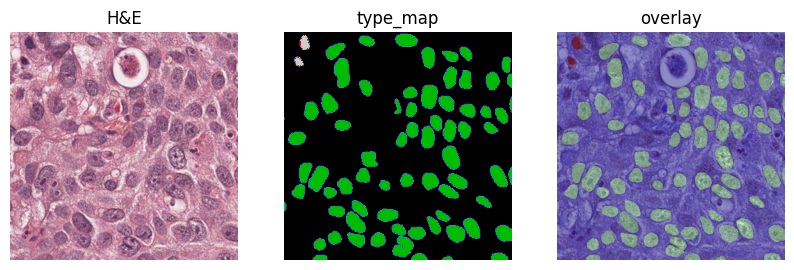

In [11]:
svs_path, xml_path = pairs[0]  
slide = openslide.OpenSlide(str(svs_path))
img0 = np.array(slide.read_region((0,0), 0, slide.level_dimensions[0]))[:, :, :3]  # RGBA→RGB

inst_map, type_map = parse_xml_to_maps(xml_path, img0.shape, min_area=MIN_POLY_AREA)
print("img size:", img0.shape, "inst_map ∪ type_map:", np.unique(type_map))

Y, X = img0.shape[:2]
y0, x0 = np.random.randint(0, max(1, Y-PATCH_SIZE)), np.random.randint(0, max(1, X-PATCH_SIZE))
patch_img  = img0[y0:y0+PATCH_SIZE, x0:x0+PATCH_SIZE]
patch_type = type_map[y0:y0+PATCH_SIZE, x0:x0+PATCH_SIZE]

vis = patch_img.copy()
cm = cv2.applyColorMap((patch_type.astype(np.float32)/patch_type.max(initial=1)*255).astype(np.uint8),
                       cv2.COLORMAP_JET)
vis = cv2.addWeighted(vis, 0.6, cm, 0.4, 0)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(patch_img); plt.title("H&E"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(patch_type, cmap="nipy_spectral"); plt.title("type_map"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.title("overlay"); plt.axis("off")
plt.show()


In [13]:
def save_patch_triplets(name_prefix, img, type_map):
    h, w = img.shape[:2]
    saved = 0
    for y in range(0, h, PATCH_SIZE):
        for x in range(0, w, PATCH_SIZE):
            patch_img = img[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
            patch_typ = type_map[y:y+PATCH_SIZE, x:x+PATCH_SIZE]

            if patch_img.shape[0] != PATCH_SIZE or patch_img.shape[1] != PATCH_SIZE:
                continue  

            if np.count_nonzero(patch_typ) == 0:
                continue

            img_name  = f"{name_prefix}_{x}_{y}.png"
            npy_name  = f"{name_prefix}_{x}_{y}.npy"
            cv2.imwrite(str(OUT_ROOT/"images"/img_name), patch_img)
            np.save(str(OUT_ROOT/"labels"/npy_name), {"type_map": patch_typ})
            saved += 1
    return saved

name = svs_path.stem
saved = save_patch_triplets(name, img0, type_map)
print(f"number of patches in {name}：", saved)


number of patches in TCGA-55-1594-01Z-00-DX1_001： 4


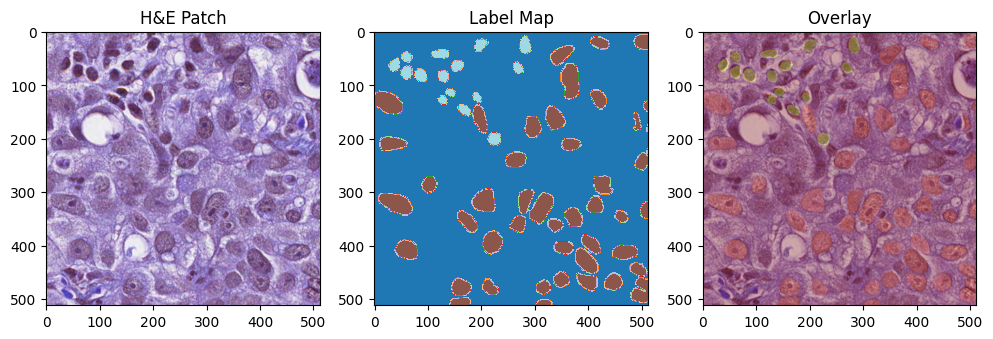

In [15]:
img_path = r""
lbl_path = r""

img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
lbl = np.load(lbl_path, allow_pickle=True).item()["type_map"]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img); plt.title("H&E Patch")
plt.subplot(1,3,2); plt.imshow(lbl, cmap="tab20"); plt.title("Label Map")
plt.subplot(1,3,3)
overlay = cv2.addWeighted(img, 0.7, cv2.applyColorMap((lbl*50).astype(np.uint8), cv2.COLORMAP_JET), 0.3, 0)
plt.imshow(overlay); plt.title("Overlay"); plt.show()


In [17]:
lbl_path = r""
data = np.load(lbl_path, allow_pickle=True).item()

print("keys:", list(data.keys()))
lbl = data["type_map"]
print("shape:", lbl.shape)
print("label:", np.unique(lbl))


keys: ['type_map']
shape: (512, 512)
label: [0 1 2]


In [19]:
unique, counts = np.unique(lbl, return_counts=True)
CELL_TYPE_MAP = {
    0: "Background",
    1: "Epithelial",
    2: "Lymphocyte",
    3: "Macrophage",
    4: "Neutrophil"
}
print("Distribution：")
for u, c in zip(unique, counts):
    print(f"{CELL_TYPE_MAP.get(u, 'Unknown'):>12}: {c} pixels ({c / lbl.size * 100:.2f}%)")


Distribution：
  Background: 216255 pixels (82.49%)
  Epithelial: 40376 pixels (15.40%)
  Lymphocyte: 5513 pixels (2.10%)


In [21]:
total_saved = 0
for svs_path, xml_path in tqdm(pairs, desc="Processing all slides"):
    slide = openslide.OpenSlide(str(svs_path))
    img0 = np.array(slide.read_region((0,0), 0, slide.level_dimensions[0]))[:, :, :3]
    inst_map, type_map = parse_xml_to_maps(xml_path, img0.shape, min_area=MIN_POLY_AREA)
    saved = save_patch_triplets(svs_path.stem, img0, type_map)
    total_saved += saved

print("number of patches：", total_saved)

Processing all slides: 100%|█████████████████████████████████████████████████████████| 209/209 [02:19<00:00,  1.50it/s]

number of patches： 200


In [22]:
from collections import Counter
import numpy as np, os
from tqdm import tqdm

LABEL_NAME = {0:"Background", 1:"Epithelial", 2:"Lymphocyte", 3:"Macrophage", 4:"Neutrophil"}

labels_dir = OUT_ROOT / "labels"
patch_files = [f for f in os.listdir(labels_dir) if f.endswith(".npy")]

per_patch_major = Counter()
pixel_count = Counter()
unique_label_set = set()

for f in tqdm(patch_files, desc="Scanning label npy"):
    d = np.load(labels_dir/f, allow_pickle=True).item()
    tm = d["type_map"].astype(np.int32)
    unique_label_set.update(np.unique(tm).tolist())
    nonzero = tm[tm>0]
    major = 0 if nonzero.size==0 else int(np.bincount(nonzero).argmax())
    per_patch_major[major]+=1
    for c in np.unique(tm):
        pixel_count[int(c)] += int((tm==c).sum())

print("All classes：", sorted(unique_label_set), "→", [LABEL_NAME.get(i,i) for i in sorted(unique_label_set)])
print("Distribution")
for k in sorted(per_patch_major.keys()):
    print(f"  {k:>1} ({LABEL_NAME[k]}): {per_patch_major[k]}")

print("number of pixels")
for k in sorted(pixel_count.keys()):
    print(f"  {k:>1} ({LABEL_NAME[k]}): {pixel_count[k]}")


Scanning label npy: 100%|████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.96it/s]

All classes： [0, 1, 2, 3, 4] → ['Background', 'Epithelial', 'Lymphocyte', 'Macrophage', 'Neutrophil']
Distribution
  1 (Epithelial): 140
  2 (Lymphocyte): 42
  3 (Macrophage): 10
  4 (Neutrophil): 8
number of pixels
  0 (Background): 42986515
  1 (Epithelial): 6864941
  2 (Lymphocyte): 2045469
  3 (Macrophage): 477829
  4 (Neutrophil): 54046
